In [1]:
#import some useful packages

import numpy as np
from qiskit.visualization import array_to_latex
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_formats = ['svg']
import time
import os
import csv

import warnings
warnings.filterwarnings('ignore')

IBMProvider.save_account('614c4821e7f7a7e9be09525472fa83916bd157e4946f23e6b657faad4dc10e3852a5ac264f0c04f5926fc1032f2fff03cb33726e91c9505c0a56691b94d1bc39', overwrite=True)
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

In [2]:
#get information about backend
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

In [3]:
qubit = 0
calibrations = backend_defaults.instruction_schedule_map
calibrations.get('x', qubit)

Schedule((0, Play(Drag(duration=120, sigma=30, beta=-0.008803701496401492, amp=0.19784192327828984, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")

In [4]:
#hyperparameters

f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9
f12 = f01 + anhar

qubit = 0
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
NUM_SHOTS = 2048
scale_factor = 1e-7

amp12 = 0.23743549524170637
dur12 = 160
sig12 = dur12/4
amp01 = 0.19778947048625103
dur01 = 120
sig01 = dur01/4

In [5]:
#some useful function
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    return LDA_012

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        #print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

def IQ_012_plot(x_min, x_max, y_min, y_max, data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

#mitigate
from cvxopt import matrix, solvers
def mitigated_population(p, C):
    P = matrix(np.transpose(C).dot(C))
    q = matrix(-np.transpose(p).dot(C))
    G = matrix([[-1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,-1.0]])
    h = matrix([0.0, 0.0, 0.0])
    A = matrix([1.0, 1.0, 1.0], (1,3))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    sol=solvers.qp(P, q, G, h, A, b)
    # return np.asarray(sol['x'])
    return np.array([e for e in sol['x']])

def get_population(data, discriminator):
    drag_values = count(data, discriminator)
    return np.asarray([[val['0']/NUM_SHOTS, val['1']/NUM_SHOTS, val['2']/NUM_SHOTS] for val in drag_values])

def get_mitigated_population(data, discriminator, confusion_matrix):
    population = get_population(data, discriminator)
    mitigated = [mitigated_population(pop, confusion_matrix) for pop in population]
    return np.asarray(mitigated)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#loss function
def loss_func(param, theta, phi, p_exp, N_data = 97):
  p_model = [population_model(theta[i], phi[i], *param, order) for i in range(N_data)]
  return mean_squared_error(p_model, population, squared = 'False')

In [6]:
#define matrix representaion of some gates
def Z01(phi):
    return np.array([[np.exp(-1j * phi), 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

def Z12(phi):
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, np.exp(1j * phi)]])

def X01(theta):
    return np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2), 0],
                     [-1j * np.sin(theta / 2), np.cos(theta / 2), 0],
                     [0, 0, 1]])


def X12(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta / 2), -1j * np.sin(theta / 2)],
                     [0, -1j * np.sin(theta / 2), np.cos(theta / 2)]])

def R01(theta, phi, phi2):
  R01_theory = Z01(phi) @ X01(theta) @ Z01(-phi)
  return Z12(phi2) @ R01_theory

def R12(theta, phi, phi0, phi2):
  R12_theory = Z12(phi) @ X12(theta) @ Z12(-phi)
  return Z01(phi0) @ Z12(phi2) @ R12_theory  

def U_d(phi_1, phi_2, phi_3):
    return np.array([[np.exp(1j*phi_1), 0, 0],
                   [0, np.exp(1j*phi_2), 0],
                   [0, 0, np.exp(1j*phi_3)]])

def R01_theory(theta, phi):
    return Z01(phi) @ X01(theta) @ Z01(-phi)

def R12_theory(theta, phi):
    return Z12(phi) @ X12(theta) @ Z12(-phi)
def population_model(thetas, phis, phi2_01, phi0_12, phi2_12, order):
    ground = np.array([[1], [0], [0]])
    psi =  R12(np.pi/2, 0, phi0_12, phi2_12) @ R01(np.pi/2, 0, phi2_01) @ ground
    i = 0
    for level in order:
        if level == '1':
            psi =  R01(thetas[i], phis[i], phi2_01) @ psi
        else :
            psi = R12(thetas[i], phis[i], phi0_12, phi2_12) @ psi
        i = i + 1
    return [np.abs(psi[0][0])**2, np.abs(psi[1][0])**2, np.abs(psi[2][0])**2]

In [7]:
#define a pulse rotating theta around n-axis in subspace 0-1 and 1-2

def r01(theta, phi):
    with pulse.build(backend=backend, default_alignment='sequential', name=r'$R^{(01)}$') as r01_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f01, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur01,
                                      amp=amp01*theta/np.pi,
                                      sigma=sig01,
                                      name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

    return r01_pulse

def r12(theta, phi):
    with pulse.build(backend=backend, default_alignment='sequential',
                     name=r'$R^{(12)}$') as r12_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f12, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur12,
                                      amp=amp12*theta/np.pi,
                                      sigma=sig12,
                                      name=r'$X_{\pi/2}^{(12)}$'), drive_chan)

    return r12_pulse

# Create the three circuits
Xpi01 = Gate("$X_{\pi}^{01}$", 1, [])
Xpi12 = Gate("$X_{\pi}^{12}$", 1, [])
X90_01 = Gate(r'$X_{\pi/2}^{(01)}$', 1, [])
X90_12 = Gate(r'$X_{\pi/2}^{(12)}$', 1, [])
# 0 state
zero = QuantumCircuit(1, 1)
zero.measure(0, 0)

# 1 state
one = QuantumCircuit(1, 1)
one.x(0)
one.measure(0, 0)

# 2 state 
two = QuantumCircuit(1, 1)
two.x(0)
two.append(Xpi12, [0])
two.measure(0, 0)
two.add_calibration(Xpi12, (0,), r12(pi, 0), [])

discr_circ = [zero, one, two]

In [8]:
def reconstruct_clifford_index(index):
    theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = clifford_params[index]
    return U_d(phi_6, phi_5, phi_4) @ R01_theory(theta_3, phi_3) @ R12_theory(theta_2, phi_2) @ R01_theory(theta_1, phi_1)

def population_theory(index):
    ground = np.array([[1], [0], [0]])
    psi = Clifford3[index] @ ground
    return np.array([np.abs(psi[0][0])**2, np.abs(psi[1][0])**2, np.abs(psi[2][0])**2])

def reconstruct_clifford_parameter(params):
    theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = params
    return U_d(phi_6, phi_5, phi_4) @ R01_theory(theta_3, phi_3) @ R12_theory(theta_2, phi_2) @ R01_theory(theta_1, phi_1)

In [9]:
exp = np.exp
d = 3 # d-dimensional Lie group, here Clifford C_3 d=3
omega = exp(2*pi*1j/d) # root of unity

sqrt = np.sqrt
exp = np.exp
pi = np.pi
arr = np.array

Hdm = 1/sqrt(3)*arr([
    [1, 1       ,   1        ],
    [1, omega   ,   omega**2 ],
    [1, omega**2,   omega    ]
])

Sdg = arr([
    [1,     0,    0        ],
    [0,     1,    0        ],
    [0,     0,    omega    ]
])


def sum_index(i):
    return 2**(i+1)-2

A = []
for i in range(12):
    if i == 0:
        A.append("H")
        A.append("S")
    else: 
        for j in range(sum_index(i-1),sum_index(i)):
            A.append(A[j]+"H")
            A.append(A[j]+"S")
            
A_matrix = []
for i in range(len(A)):
    result = np.complex128(np.zeros([3,3]))
    for j in range(len(A[i]),):
        if j == 0:
            if A[i][j] == 'H': result += Hdm
            elif A[i][j] == 'S': result += Sdg
        else:
            if A[i][j] == 'H': result = result@Hdm
            elif A[i][j] =='S': result = result@Sdg
    A_matrix.append(result)
    
A_matrix_flitered = []
A_matrix_flitered_index = []
for i in range(len(A_matrix)):
    if i == 0:
        A_matrix_flitered.append(A_matrix[i])
        A_matrix_flitered_index.append(i)
    else:
        flag = True
        for j in range(len(A_matrix_flitered)):
            if (np.round(A_matrix[i] - A_matrix_flitered[j], decimals = 10) == 0).all():
                flag = False
                break
            else: 
                continue
        if flag == True:
            A_matrix_flitered.append(A_matrix[i])
            A_matrix_flitered_index.append(i)
            
for i in range(len(A_matrix_flitered)):
    A_matrix_flitered[i] = np.round(A_matrix_flitered[i], decimals = 10)
    
Clifford3 = A_matrix_flitered
Clifford3_latex = [array_to_latex(mat) for mat in Clifford3]

In [10]:
len(Clifford3)

937

In [11]:
def is_global_phase(mat_1, mat_2):
    for i in range(3):
        if mat_1[0][i] != 0:
            arg_1 = np.angle(mat_1[0][i])
            arg_2 = np.angle(mat_2[0][i])
            break
        else:
            continue
    identity = np.identity(3, np.complex128)
    zeros = np.zeros([3,3], np.complex128)
    diff = mat_1 * np.exp(1j*arg_2) - mat_2 * np.exp(1j*arg_1)
    if (np.round(diff, decimals=10)==0).all():
        return True
    else:
        return False
        

In [12]:
global_phase = []
for i in range(len(Clifford3)):
    wrong = [i]
    for j in range(i+1, len(Clifford3)):
        if is_global_phase(Clifford3[i], Clifford3[j]):
            wrong.append(j)
    global_phase.append(wrong)



In [13]:
no_need = set()
for i in range(len(global_phase)):
    for j in range(1, len(global_phase[i])):
        no_need.add(global_phase[i][j])
        
len(no_need)

721

In [14]:
index = np.arange(0, len(Clifford3))

right_index = np.delete(index, list(no_need))
print(len(right_index))

Clifford3_update = []
for i in right_index:
    Clifford3_update.append(Clifford3[i])

216


In [15]:
pairs_inv = []
for i in range(len(Clifford3_update)):
    res = [i]
    for j in range(0, len(Clifford3_update)):
        mat = Clifford3_update[i]@Clifford3_update[j]
        iden = np.identity(3, np.complex128)
        arg = np.angle(mat[0][0])
        #print(arg)
        iden_2 = iden * exp(1j*arg)
        if (np.round(mat - iden_2, decimals=10) == 0).all():
            #print(i)
            #print(arg)
            res.append(j)
            #res.append(arg, decimals=9)
    pairs_inv.append(res)

In [16]:
def check_pairs(lst):
    if lst[1] >= lst[0]:
        return True
    else:
        return False
short_pairs_inv = []
for pair in pairs_inv:
    if check_pairs(pair):
        #print(pair)
        short_pairs_inv.append(pair)

In [17]:
len(short_pairs_inv)

113

In [18]:
Clifford3_final = Clifford3_update

In [19]:
def multi(lst):
    mat = np.identity(3, np.complex128)
    for i in lst:
        mat = mat @ Clifford3_final[i]
    return mat

In [20]:
def is_global_phase(mat_1, mat_2):
    for i in range(3):
        if mat_1[0][i] != 0:
            arg_1 = np.angle(mat_1[0][i])
            arg_2 = np.angle(mat_2[0][i])
            break
        else:
            continue
    #print(arg_1, arg_2)
    identity = np.identity(3, np.complex128)
    zeros = np.zeros([3,3], np.complex128)
    diff = mat_1 * np.exp(1j*arg_2) - mat_2 * np.exp(1j*arg_1)
    if (np.round(diff, decimals=6)==0).all():
        return True
    else:
        return False
        

In [21]:
def find_index(mat):
    index = -1
    for i in range(216):
        if is_global_phase(mat, Clifford3_final[i])==True:
            index = i
    return index

def find_inv_index(index):
    inv_index = -1
    for pair in pairs_inv:
        if pair[0] == index:
            inv_index = pair[1]
        if pair[1] == index:
            inv_index = pair[0]
    return inv_index

def rmb(length):
    sequence = np.random.randint(0, 216, length)
    mat = multi(np.flip(sequence))
    index_mat = find_index(mat)
    inv_index = find_inv_index(index_mat)
    while inv_index == -1:
        sequence = np.random.randint(0, 216, length)
        mat = multi(np.flip(sequence))
        index_mat = find_index(mat)
        inv_index = find_inv_index(index_mat)
    rmb_sequence = np.concatenate((sequence, np.array([inv_index])))
    return rmb_sequence

def check_is_inv(lst):
    rand_index = lst[:len(lst)-1]
    mat = multi(np.flip(rand_index))
    ground = np.array([[1], [0], [0]])
    psi = Clifford3_final[lst[-1]]@mat@ground
    #print(psi)
    if np.round(np.abs(psi[0])) == 1:
        return True
    else:
        return False
    
def psi(lst):
    rand_index = lst[:len(lst)-1]
    mat = multi(np.flip(rand_index))
    ground = np.array([[1], [0], [0]])
    psi = Clifford3_final[lst[-1]]@mat@ground
    return array_to_latex(psi)

In [22]:
def get_parameter(index):
    U = Clifford3_final[index]
    if np.round(abs(np.absolute(U[2, 2])), 6) == 1:
        if np.round(abs(np.absolute(U[0, 0])), 6) != 0:
            theta_1 = phi_1 = theta_2 = phi_2 = 0
            phi_4 = np.angle(U[2, 2])
            phi_5 = np.angle(U[1, 1])
            phi_6 = np.angle(U[0, 0])
            # phi_3 = phi_6 - pi/2 - np.angle(U[0, 1])
            phi_3 = np.angle(U[1, 0]) - phi_5 + pi/2
            theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 1]), 6))
        else:
            theta_1 = phi_1 = theta_2 = phi_2 = phi_3 = 0
            theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 1]), 6))
            phi_4 = np.angle(U[2, 2])
            phi_6 = np.angle(U[0, 1]) + phi_3 + pi/2
            phi_5 = np.angle(U[1, 0]) - phi_3 + pi/2
    elif np.round(abs(np.absolute(U[2, 2])), 6) == 0:
        theta_1 = 2*np.arccos(np.round(np.absolute(U[2, 1]), 6))
        theta_2 = pi
        theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 2]), 6))
        phi_1 = phi_2 = phi_3 = 0
        if np.round(abs(np.absolute(U[2, 0])), 6) != 0:
            phi_4 = np.angle(-U[2, 0])
            if np.round(abs(np.absolute(U[0, 2])), 6) != 0:
                phi_5 = np.angle(-U[1, 1])
                phi_6 = np.angle(-U[0, 2])
            else:
                phi_5 = np.angle(U[1, 2]) + pi/2
                phi_6 = np.angle(U[0, 1]) + pi/2 
        if np.round(abs(np.absolute(U[1, 0])), 6) != 0:
            phi_4 = np.angle(U[2, 1]) + pi/2
            phi_5 = np.angle(U[1, 0]) + pi/2
            phi_6 = np.angle(-U[0, 2])
        if np.round(abs(np.absolute(U[0, 0])), 6) != 0:
            phi_4 = np.angle(U[2, 1]) + pi/2
            phi_5 = np.angle(U[1, 2]) + pi/2
            phi_6 = np.angle(U[1, 1])
        
    else:
        phi_4 = np.angle(U[2, 2])
        theta_2 = 2*np.arccos(np.round(np.absolute(U[2, 2]), 6))
        phi_2 = np.angle(U[2, 1]) - phi_4 + pi/2
        phi_1 = np.angle(-U[2, 0]) - phi_2 - phi_4
        theta_1 = 2*np.arccos(np.round(np.absolute(U[2, 1])/np.sin(theta_2/2), 6))
        theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 2])/np.sin(theta_2/2), 6))
        phi_5 = np.angle(U[1, 2]) + phi_2 + pi/2
        phi_3 = np.angle(np.cos(theta_1/2) * np.cos(theta_2/2) * np.cos(theta_3/2) - U[1, 1]*np.exp(-1j*phi_5)) + phi_1
        phi_6 = np.angle(-U[0, 2]) + phi_3 + phi_2
    return theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6

def reconstruct(theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6):
    return U_d(phi_6, phi_5, phi_4) @ R01_theory(theta_3, phi_3) @ R12_theory(theta_2, phi_2) @ R01_theory(theta_1, phi_1)

In [23]:
def find_bug():
    bug = []
    for i in range(216):
        mat_gen = Clifford3_final[i]
        theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = get_parameter(i)
        mat_reconstruct = reconstruct(theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6)
        diff = np.round(mat_gen-mat_reconstruct, 5)
        if np.absolute(np.sum(diff)) != 0:
            bug.append(i)
    return bug

bug = find_bug()

bug

[]

In [24]:
#data = [get_parameter(i) for i in range(216)]

In [25]:
#np.savetxt('clifford_parameter_update.csv', data, delimiter=',')

In [26]:
clifford3_params = np.genfromtxt('clifford_parameter_update.csv', delimiter=',')

In [27]:
def create_pulse_sequence(params_sequence):
    phase_01, phase_12 = 0, 0
    #print(alpha, beta, gamma)
    with pulse.build(backend=backend, default_alignment='sequential') as pulse_sequence:
        drive_channel = pulse.drive_channel(qubit)
        pulse.delay(0, drive_channel)
    for params in params_sequence:
        #print(params)
        theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = params
        
        with pulse.build(backend=backend, default_alignment='sequential') as sched:
            drive_channel = pulse.drive_channel(qubit)
            
            #R01(theta, phi)
            pulse.set_frequency(f01, drive_channel)
            pulse.call(r01(theta_1, phi_1 + phase_01))
            phase_12 = phase_12 + alpha
            
            #R12(theta, phi)           
            pulse.set_frequency(f12, drive_channel)
            pulse.call(r12(theta_2, phi_2 + phase_12))
            phase_01 = phase_01 + beta
            phase_12 = phase_12 + gamma
            
            #R01(theta, phi)      
            pulse.set_frequency(f01, drive_channel)
            pulse.call(r01(theta_3, phi_3 + phase_01))
            phase_12 = phase_12 + alpha
            
            #U_d(phi6, phi5, phi4)
            phase_01 = phase_01 + phi_6 - phi_5
            phase_12 = phase_12 + phi_5 - phi_4

        pulse_sequence = pulse_sequence + sched
        #print(phase_01, phase_12)
    return pulse_sequence

In [28]:
def rmb_circ(length):
    rmb_seq = 0
    if length == 0:
        qc = QuantumCircuit(1,1)
        qc.measure(0,0)
    else:
        rmb_seq = rmb(length)
        rmb_params = [clifford3_params[index] for index in rmb_seq]
        #print(rmb_seq)
        rmb_pulse = create_pulse_sequence(rmb_params)
        rmb_gate = Gate('RMB', 1, [])
        qc = QuantumCircuit(1,1)
        qc.append(rmb_gate, [0])
        qc.add_calibration(rmb_gate, (0,), rmb_pulse, [])
        qc.measure(0, 0)
    return qc

In [42]:
alpha, beta, gamma = np.array([4.55047476, 0.22474651, 0.03502484])
#alpha, beta, gamma = np.array([0, 0, 0])

In [43]:
NUM_SHOTS

2048

In [52]:
#average of 50 jobs, each job runs from length 1 to 97
list_id = []
for i in range(1):
    rmb_circs = [rmb_circ(length) for length in range(1, 298)]
    rmb_circs = discr_circ + rmb_circs
    rmb_job = backend.run(rmb_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
    print(rmb_job.job_id())
    list_id.append(rmb_job.job_id())

cnaxkjyp25300086w8ag


In [66]:
len(rmb_circs)

300

In [70]:
rmb_circs[3].draw()

┌─────┐┌─┐
  q: ┤ RMB ├┤M├
     └─────┘└╥┘
c: 1/════════╩═
             0

In [1]:
with open('job_id_rmb_292_389_030_2023_20_08.txt', 'r') as f:
    list_id = [s.strip() for s in f.readlines()]

In [58]:
rmb_job = provider.backend.retrieve_job("cnaxkjyp25300086w8ag")
job_monitor(rmb_job)

Job Status: job has successfully run


In [59]:
#rmb_job = provider.backend.retrieve_job(id)
rmb_data = get_job_data(rmb_job, average=False)
discrim_data = rmb_data[:3]
exp_data = rmb_data[3:]
LDA_012 = discriminate(discrim_data)
discr_data = count(discrim_data, LDA_012)
conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
population = get_mitigated_population(exp_data, LDA_012, conf_mat)

In [62]:
conf_mat

[[0.0029296875, 0.4287109375, 0.568359375],
 [0.00390625, 0.44873046875, 0.54736328125],
 [0.00439453125, 0.41943359375, 0.576171875]]

Text(0.5, 1.0, 'RMB with phase correction')

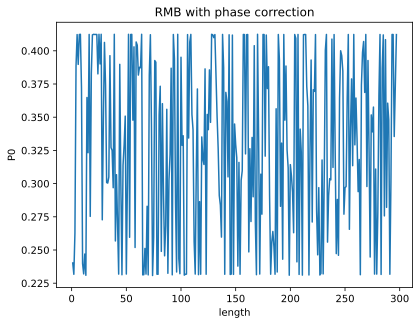

In [61]:
plt.plot(np.arange(1, 298), population[:, 0])
plt.xlabel("length")
plt.ylabel("P0")
plt.title("RMB with phase correction")
#plt.savefig("rmb_phase")

In [64]:
populations = []
mats = []
i = 0
for id in list_id:
    rmb_job = provider.backend.retrieve_job(id)
    rmb_data = get_job_data(rmb_job, average=False)
    discrim_data = rmb_data[:3]
    exp_data = rmb_data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    mats.append(conf_mat)
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    populations.append(population)
    print('successful retrieve job ' + str(i))
    i = i + 1


successful retrieve job 0


In [65]:
for mat in mats:
    if min(mat[0][0], mat[1][1], mat[2][2]) < 0.8:
        print(mat)


[[0.30615234375, 0.30322265625, 0.390625], [0.3046875, 0.31103515625, 0.38427734375], [0.3046875, 0.291015625, 0.404296875]]


In [63]:
mats

[[[0.87646484375, 0.03564453125, 0.087890625],
  [0.03759765625, 0.8740234375, 0.08837890625],
  [0.0107421875, 0.107421875, 0.8818359375]],
 [[0.90966796875, 0.029296875, 0.06103515625],
  [0.03271484375, 0.8857421875, 0.08154296875],
  [0.01025390625, 0.08544921875, 0.904296875]],
 [[0.90576171875, 0.029296875, 0.06494140625],
  [0.03759765625, 0.8740234375, 0.08837890625],
  [0.0126953125, 0.0947265625, 0.892578125]]]

In [47]:
rmb_populations = [populations[i][:, 0] for i in range(len(populations))]
rmb_populations = np.array([list(population) for population in rmb_populations])

In [48]:
average_populations = np.zeros((1, 97))
for i in range(len(populations)):
    average_populations = average_populations + populations[i][:, 0]


In [49]:
average_populations = average_populations/len(populations)
average_populations

array([[0.77479214, 0.94539009, 0.9842711 , 0.9762181 , 0.95654297,
        0.94575876, 0.91906796, 0.93187318, 0.96531677, 0.91945871,
        0.93648666, 0.92668772, 0.84793023, 0.86956763, 0.76128549,
        0.86391695, 0.70183713, 0.75252583, 0.65228218, 0.72693554,
        0.81900953, 0.72346546, 0.71646036, 0.73535314, 0.53666054,
        0.67768392, 0.61148151, 0.70850525, 0.63146794, 0.63062477,
        0.6062912 , 0.72929503, 0.60010802, 0.55465799, 0.65264294,
        0.48300395, 0.65319394, 0.65562238, 0.78746615, 0.46338819,
        0.76510357, 0.66812321, 0.55368668, 0.64019517, 0.59112243,
        0.42935369, 0.73561948, 0.54693809, 0.68912327, 0.66929861,
        0.63942077, 0.57880527, 0.49461275, 0.53481529, 0.48924943,
        0.53707835, 0.63939218, 0.60827663, 0.50304647, 0.62215139,
        0.49074993, 0.49126632, 0.52013772, 0.48253785, 0.39614399,
        0.48684118, 0.5021206 , 0.487291  , 0.53160762, 0.54478299,
        0.58958788, 0.54347597, 0.6165795 , 0.57

In [50]:
average_populations.shape

(1, 97)

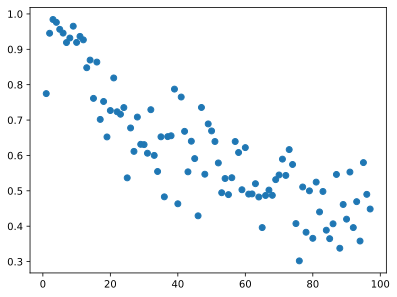

In [51]:
plt.scatter(np.arange(1, average_populations.shape[1]+1),average_populations[0]) 

In [31]:
list_id_292_389 = ['cjc8dtol9m0cicrvtatg',
'cjc8igunq2dtf22g0kag',
'cjc8mss3bgbkhnriiba0',
'cjc8r7ol9m0cics0m2rg',
'cjc8vmklik6102sg5i60',
'cjc943rqmesgannol7l0',
'cjc98r8l9m0cics1eth0',
'cjc9dok3bgbkhnrjs10g',
'cjc9ijttks61ugqfef00',
'cjc9n2ltks61ugqfm6lg',
'cjc9rlslik6102shnkm0',
'cjca08slik6102shvno0',
'cjca58rqmesgannqg9p0',
'cjcaa78l9m0cics3acog',
'cjcaeo4lik6102sipkig',
'cjcaj5clik6102sj18ug',
'cjcanlslik6102sj99ug',
'cjcas5ttks61ugqhm1v0',
'cjcb0kslik6102sjp7hg',
'cjcb563qmesganns8nqg',
'cjcb9os3bgbkhnrn618g',
'cjcbe0clik6102skg1i0',
'cjcbjf5tks61ugqit210',
'cjcbp8clik6102sl3b4g',
'cjcbuqjqmesganntk7r0',
'cjcc4iclik6102slmrc0',
'cjcc90jqmesgannu5m20',
'cjccdgenq2dtf22mutkg',
'cjcci2clik6102sme5h0',
'cjccm95tks61ugqkn8pg',
'cjccri0l9m0cics7n9hg',
'cjcd0vs3bgbkhnrq4bo0',
'cjcd6cdtks61ugqlhv7g',
'cjcdcfclik6102snqv8g',
'cjcdi6s3bgbkhnrr1ms0',
'cjcdo0enq2dtf22p9apg',
'cjcdthc3bgbkhnrrl6q0',
'cjce2f3qmesgang17n90',
'cjce77enq2dtf22q4600',
'cjcec1unq2dtf22qccv0',
'cjcegtunq2dtf22qkh40',
'cjceljbqmesgang27610',
'cjceq7slik6102sq80gg',
'cjceutklik6102sqfgng',
'cjcf3ijqmesgang2top0',
'cjcf93mnq2dtf22rsu7g',
'cjcfekmnq2dtf22s6k8g',
'cjcfk63qmesgang3q030',
'cjcfpmk3bgbkhnrupk4g'
'cjcg7j5tks61ugqqhn9g']

In [45]:
len(list_id_292_389)

49

In [46]:
file_name = 'job_id_rmb_292_389_030.txt'
with open(file_name, 'w') as f:
    for job_id in list_id_292_389:
        f.write(job_id)
        f.write('\n')

In [31]:
populations = []
mats = []
for id in list_id_292_389[:5]:
    rmb_job = provider.backend.retrieve_job(id)
    rmb_data = get_job_data(rmb_job, average=False)
    discrim_data = rmb_data[:3]
    exp_data = rmb_data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    mats.append(conf_mat)
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    populations.append(population)

In [32]:
for id in list_id_292_389[6:]:
    rmb_job = provider.backend.retrieve_job(id)
    rmb_data = get_job_data(rmb_job, average=False)
    discrim_data = rmb_data[:3]
    exp_data = rmb_data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    mats.append(conf_mat)
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    populations.append(population)

IBMBackendApiError: 'Failed to get job cjcfpmk3bgbkhnrupk4gcjcg7j5tks61ugqqhn9g: \'404 Client Error: Not Found for url: https://runtime-us-east.quantum-computing.ibm.com/facade/v1/jobs/cjcfpmk3bgbkhnrupk4gcjcg7j5tks61ugqqhn9g/type. {"errors":[{"code":1291,"message":"Job not found. Job ID: cjcfpmk3bgbkhnrupk4gcjcg7j5tks61ugqqhn9g","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"cje2i0l0d4dvqnpn4uog"}\''

In [33]:
len(populations)

47

In [35]:
for mat in mats:
    if min(mat[0][0], mat[1][1], mat[2][2]) < 0.85:
        print(mat)

In [36]:
rmb_populations = [populations[i][:, 0] for i in range(len(populations))]
rmb_populations = np.array([list(population) for population in rmb_populations])

In [37]:
max_data = [np.max(rmb_populations[:, i]) for i in range(len(rmb_populations[0]))]
min_data = [np.min(rmb_populations[:, i]) for i in range(len(rmb_populations[0]))]

In [38]:
average_populations = np.zeros((1, 97))
for i in range(47):
    average_populations = average_populations + populations[i][:, 0]


In [39]:
average_populations = average_populations/47
average_populations

array([[0.34431559, 0.33604269, 0.34103028, 0.34644566, 0.35382604,
        0.35419348, 0.32824292, 0.33540911, 0.33758092, 0.35552066,
        0.3339204 , 0.33871711, 0.33837337, 0.34665819, 0.34542025,
        0.33808609, 0.34303837, 0.3451662 , 0.34891954, 0.34585717,
        0.33639571, 0.34749106, 0.34445084, 0.33782042, 0.34381503,
        0.33943507, 0.34529372, 0.3434486 , 0.33938006, 0.33004711,
        0.33864169, 0.34334738, 0.33495161, 0.33344764, 0.34835649,
        0.3399847 , 0.3450106 , 0.32979906, 0.34164311, 0.33038944,
        0.33873478, 0.34472852, 0.33770811, 0.33748808, 0.34162593,
        0.33294834, 0.34978846, 0.34946377, 0.33997347, 0.34034184,
        0.33287539, 0.33576595, 0.34106814, 0.33923271, 0.32963156,
        0.3453812 , 0.33972445, 0.32976692, 0.3331945 , 0.34052575,
        0.32584659, 0.32925884, 0.33649642, 0.34566756, 0.3438195 ,
        0.34084753, 0.34481395, 0.33626846, 0.33596525, 0.3265433 ,
        0.32179516, 0.33378133, 0.33748154, 0.32

In [60]:
file_name = 'id_1_49.txt'
with open(file_name, 'w') as f:
    for job_id in list_id:
        f.write(job_id)
        f.write('\n')

In [50]:
list_id = []
for i in range(1, 2):
    rmb_circs = []
    for j in range(97):
        rmb_circs.append(rmb_circ(i))
    rmb_circs = discr_circ + rmb_circs
    #rmb_job = backend.run(rmb_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
    #list_id.append(rmb_job.job_id())

In [51]:
len(rmb_circs)

100

In [68]:
check = []
rmb_circs = []
for i in range(97):
    rmb_qc, rmb_seq = rmb_circ(i)
    check.append(rmb_seq)
    rmb_circs.append(rmb_qc)
    
rmb_circs = discr_circ + rmb_circs

In [68]:
list_id_291 = []
for i in range(10):
    rmb_circs = [rmb_circ(length) for length in range(194, 291)]
    rmb_circs = discr_circ + rmb_circs
    rmb_job = backend.run(rmb_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
    list_id_291.append(rmb_job.job_id())

IBMBackendApiError: 'Error submitting job: "(\'Connection aborted.\', TimeoutError(\'The write operation timed out\'))"'

In [81]:
rmb_circs = [rmb_circ(length) for length in range(194, 291)]

In [33]:
with open('Order_2023_6_28_ibm_lagos.txt', 'r') as f:
    orders = [s.strip() for s in f.readlines()]

97

In [82]:
list_id_291

[]

In [56]:
file_name = 'id_0_96.txt'
with open(file_name, 'w') as f:
    for job_id in list_id_97:
        f.write(job_id)
        f.write('\n')

In [57]:
file_name = 'id_97_193.txt'
with open(file_name, 'w') as f:
    for job_id in list_id_194:
        f.write(job_id)
        f.write('\n')

In [58]:
file_name = 'id_194_290.txt'
with open(file_name, 'w') as f:
    for job_id in list_id_291:
        f.write(job_id)
        f.write('\n')

In [52]:
list_id_97 = ['cirrnt3c2439q365ecg0',
 'cirro9llipn2bccsaqog',
 'cirroml5earflft1p8pg',
 'cirrp3llipn2bccsc47g',
 'cirrph4t4v68ftdth8gg',
 'cirrpvkt4v68ftdthvq0',
 'cirrqdst4v68ftdtipbg',
 'cirrqrdlipn2bccsf170',
 'cirrra55earflft1tig0',
 'cirrrnt5earflft1u6ng']

In [53]:
list_id_194 = ['cirs8ft5earflft2jn1g',
 'cirs9l4t4v68ftdubg40',
 'cirsao55earflft2nd4g',
 'cirsbumuepl821998th0',
 'cirsd5muepl821999m50',
 'cirseg55earflft2qpkg',
 'cirsfotlipn2bcctdg90',
 'cirsh1jc2439q366j4cg',
 'cirsid55earflft2tp8g',
 'cirsjm3c2439q366l5i0']

In [54]:
list_id_291 = ['ciu9ahp0lhfmb5re24dg',
               'ciu9ccp1s2cfkgvrp3c0']

In [33]:
with open('id_1_49.txt', 'r') as f:
    list_id = [s.strip() for s in f.readlines()]

In [38]:
mats = []
populations = []
for id in list_id:
    job = provider.backend.retrieve_job(id)
    data = get_job_data(job, average = False)
    
    discrim_data = data[:3]
    exp_data = data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
#confusion matrix
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    mats.append(conf_mat)
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    populations.append(population)

In [42]:
for mat in mats:
    if min(mat[0][0], mat[1][1], mat[2][2]) < 0.85:
        print(mat)


In [45]:
average_populations = [np.average(population, axis=0) for population in populations]

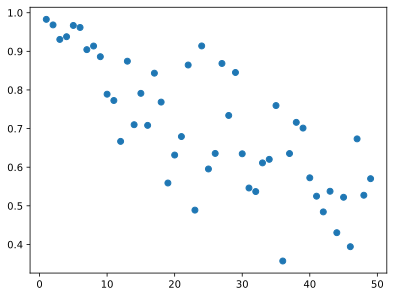

In [52]:
plt.scatter(np.arange(1, len(average_populations)+1), np.array(average_populations)[:, 0])

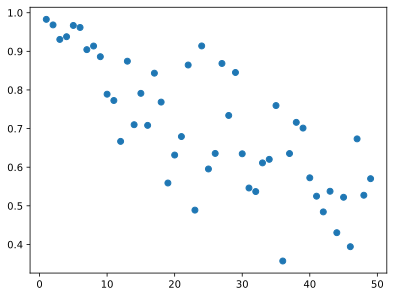

In [57]:
plt.scatter(np.arange(1, len(aver)+1), np.array(aver)[:, 0])

In [56]:
aver = [np.average(populations[i], axis=0) for i in range(len(populations))]
aver

[array([0.98284714, 0.00778667, 0.0093662 ]),
 array([0.96843046, 0.02893917, 0.00263036]),
 array([0.93085271, 0.03407471, 0.03507258]),
 array([0.93786386, 0.03029336, 0.03184278]),
 array([0.9670181 , 0.01270954, 0.02027236]),
 array([0.96181607, 0.0279297 , 0.01025423]),
 array([0.90440168, 0.06427622, 0.0313221 ]),
 array([0.91374176, 0.01459488, 0.07166336]),
 array([0.88612776, 0.03964844, 0.0742238 ]),
 array([0.7890457 , 0.07192742, 0.13902689]),
 array([0.77272211, 0.04083869, 0.1864392 ]),
 array([0.66688037, 0.0646482 , 0.26847143]),
 array([0.87448957, 0.10868863, 0.0168218 ]),
 array([0.71003917, 0.12175551, 0.16820532]),
 array([0.79123809, 0.08288147, 0.12588044]),
 array([0.70834168, 0.13765141, 0.15400691]),
 array([0.84345696, 0.12778776, 0.02875528]),
 array([0.76858965, 0.13718545, 0.0942249 ]),
 array([0.55907881, 0.12422051, 0.31670068]),
 array([0.63148165, 0.33590394, 0.0326144 ]),
 array([0.679395  , 0.16731126, 0.15329374]),
 array([0.86458892, 0.07598442, 0.

In [34]:
data = []
average_populations = []
i = 1
mats = []
for id in list_id:
    rmb_job = provider.backend.retrieve_job(id)
    rmb_data = get_job_data(rmb_job, average=False)
    np.savetxt(f'rmb_data_{i}.csv', rmb_data, delimiter=',')
    discrim_data = rmb_data[:3]
    exp_data = rmb_data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    mats.append(conf_mat)
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    #data.append(population)
    average_populations.append(np.average(population, axis=0))
    i = i + 1

In [55]:
populations = []
for i in range(1, 50):
    #rmb_job = provider.backend.retrieve_job(id)
    #rmb_data = get_job_data(rmb_job, average=False)
    #np.savetxt(f'rmb_data_{i}.csv', rmb_data, delimiter=',')
    rmb_data = np.genfromtxt(f'rmb_data_{i}.csv', delimiter=',', dtype=np.complex)
    discrim_data = rmb_data[:3]
    exp_data = rmb_data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    #mats.append(conf_mat)
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    populations.append(population)
    #average_populations.append(np.average(population, axis=0))
    #i = i + 1

In [56]:
populations

[array([[9.57269295e-01, 1.36036998e-02, 2.91270048e-02],
        [9.99989371e-01, 9.20445563e-06, 1.42459197e-06],
        [9.71161362e-01, 1.16605651e-02, 1.71780730e-02],
        [9.70910202e-01, 1.39136603e-02, 1.51761375e-02],
        [9.94732377e-01, 3.73463703e-03, 1.53298639e-03],
        [9.72843139e-01, 1.29959988e-02, 1.41608626e-02],
        [9.63593866e-01, 1.11898999e-03, 3.52871443e-02],
        [9.74062454e-01, 1.13603886e-02, 1.45771575e-02],
        [9.73958165e-01, 1.02293868e-02, 1.58124487e-02],
        [9.74059572e-01, 1.00709948e-02, 1.58694336e-02],
        [9.99477538e-01, 5.21664167e-04, 7.97928493e-07],
        [9.72026774e-01, 1.16833714e-02, 1.62898549e-02],
        [9.72639799e-01, 1.32058965e-02, 1.41543050e-02],
        [9.62413746e-01, 3.75420803e-02, 4.41731622e-05],
        [9.71874620e-01, 1.20020325e-02, 1.61233472e-02],
        [9.99829396e-01, 1.43546066e-04, 2.70578576e-05],
        [9.72536044e-01, 1.18043137e-02, 1.56596426e-02],
        [9.720

In [36]:
average_popus = [list(popu) for popu in average_populations]

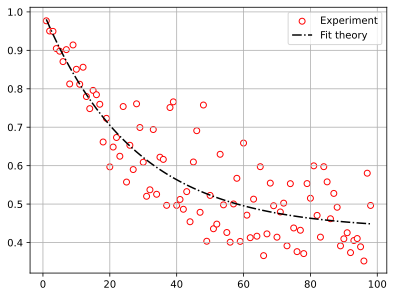

In [49]:
plt.scatter(np.arange(1, 99), np.array(average_popus)[:, 0], marker='o', edgecolor='red', color='white', label='Experiment')
plt.plot(np.arange(1, 99), y_fit, linestyle='-.', color='black', linewidth=1.5, label='Fit theory')
plt.grid()
plt.legend()

In [46]:
fit_params, y_fit = fit_function(np.arange(1, 99), 
                                 np.array(average_popus)[:, 0], 
                                 lambda m, A, B, p: A*p**m + B,
                                 [0.5, 0.5, 1])

In [47]:
A, B, p = fit_params

In [48]:
p

0.9638292841292554

In [70]:
bug = []
for i in range(1, len(check)):
    #print(check[i])
    if check_is_inv(check[i]):
        continue
    else:
        bug.append(check[i])

In [71]:
bug

[]

In [72]:
#rmb_circs = [rmb_circ(i) for i in range(97)]
#rmb_circs = discr_circ + rmb_circs

In [73]:
rmb_job = backend.run(rmb_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
print(rmb_job.job_id())

cirrmmeuepl821986ldg


In [36]:
job = provider.backend.retrieve_job('ciu9ahp0lhfmb5re24dg')
data = get_job_data(job, average = False)

In [37]:
discrim_data = data[:3]
exp_data = data[3:]

In [38]:
LDA_012 = discriminate(discrim_data)
discr_data = count(discrim_data, LDA_012)
#confusion matrix
conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
conf_mat

[[0.9628, 0.011, 0.0262],
 [0.01205, 0.95185, 0.0361],
 [0.01645, 0.059, 0.92455]]

In [39]:
population = get_mitigated_population(exp_data, LDA_012, conf_mat)

In [43]:
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit
from scipy.optimize import curve_fit

In [74]:
fit_params, y_fit = fit_function(np.arange(1, 291), 
                                 aver_popus[1:, 0], 
                                 lambda m, A, B, p: A*p**m + B,
                                 [0.5, 0.5, 1])

In [75]:
A, B, p = fit_params

In [76]:
p

0.9832016985554255

In [77]:
r = 1 - p - (1 - p)/3
r

0.011198867629716336

In [78]:
y_fit[-1]

0.353342497586734

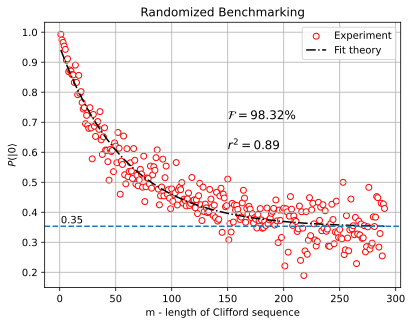

In [96]:
plt.scatter(np.arange(1, 291), aver_popus[1:, 0], marker='o', edgecolor='red', color='white', label='Experiment')
plt.plot(np.arange(1, 97+97+97), y_fit, linestyle='-.', color='black', linewidth=1.5, label='Fit theory')
plt.grid()
plt.legend()
plt.axhline(y_fit[-1], linestyle='--')
plt.annotate("", xy=(1, 0), xytext=(1/2,0), arrowprops=dict(arrowstyle="<->"))
plt.annotate(np.round(y_fit[-1], 2), xy=(1, y_fit[-1]+0.01))
plt.xlabel('m - length of Clifford sequence')
plt.text(150, 0.71, r'$\mathcal{F}=98.32\%$', fontsize=12)
plt.text(150, 0.61, r'$r^2=0.89$', fontsize=12)
plt.title('Randomized Benchmarking')
plt.ylabel(r'$P(|0\rangle$')

plt.savefig('rmb_aver_294')